In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange

from torchtext.data import Field
from torchtext.vocab import GloVe
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import BertTokenizer, BertModel

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

from utils import preprocessing
from utils.training import train, infer, predict_sexism

sns.set_style('darkgrid')

In [2]:
# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# BERT

## Datos

In [4]:
train_df = pd.read_csv('../../Data/EXIST2021_training.tsv', sep='\t')
train_df = train_df[train_df['task1'] == 'sexist']

# Un simple pre-procesamiento
train_df['text'] = train_df['text'].apply(lambda text: preprocessing.preprocess(text))

# Codificamos las etiquetas
label_encoder = LabelEncoder()
label_encoder.fit(train_df['task2'])

train_df['label'] = label_encoder.transform(train_df['task2'])

train_df.head()

,test_case,id,source,language,text,task1,task2,label
0,EXIST2021,1,twitter,en,"she calls herself "" anti-feminazi "" how about ...",sexist,ideological-inequality,0
2,EXIST2021,3,twitter,en,"wow , your skirt is very short . what is it's ...",sexist,objectification,2
5,EXIST2021,6,twitter,en,hello ... m raj ... m with good size and excel...,sexist,sexual-violence,3
10,EXIST2021,11,twitter,en,you weren't actually what ? this is not a pain...,sexist,ideological-inequality,0
15,EXIST2021,16,twitter,en,i don't know any feminists who think the way y...,sexist,ideological-inequality,0


In [5]:
test_df = pd.read_csv('../../Data/EXIST2021_test.tsv', sep='\t')
test_df = test_df[test_df['task1'] == 'sexist']

# Un simple pre-procesamiento
test_df['text'] = test_df['text'].apply(lambda text: preprocessing.preprocess(text))

test_df['label'] = label_encoder.transform(test_df['task2'])

test_df.head()

,test_case,id,source,language,text,task1,task2,label
2,EXIST2021,6980,twitter,en,"lol ! "" this behavior of not letting men tell ...",sexist,ideological-inequality,0
3,EXIST2021,6981,twitter,en,rights ? i mean yeah most women especially the...,sexist,ideological-inequality,0
7,EXIST2021,6985,twitter,en,stop regarding women as animals who forget tht...,sexist,ideological-inequality,0
8,EXIST2021,6986,gab,en,"yeah , it is rough , but not for women . marri...",sexist,objectification,2
11,EXIST2021,6989,twitter,en,you were publicly harassing a girl by constant...,sexist,misogyny-non-sexual-violence,1


In [6]:
label_encoder.classes_

array(['ideological-inequality', 'misogyny-non-sexual-violence',
       'objectification', 'sexual-violence', 'stereotyping-dominance'],
      dtype=object)

In [7]:
# # Ya está preprocesado
# train_df = pd.read_csv('../../Data/EXIST2021_training_spell_checked.csv', sep=',')

# # Codificamos las etiquetas
# label_encoder = LabelEncoder()
# label_encoder.fit(train_df['task1'])

# train_df['label'] = label_encoder.transform(train_df['task1'])

# train_df.head()

In [8]:
# # Ya está preprocesado
# test_df = pd.read_csv('../../Data/EXIST2021_test_spell_checked.csv', sep=',')

# test_df['label'] = label_encoder.transform(test_df['task1'])

# test_df.head()

### Dataloaders

En [Huggingface models](https://huggingface.co/models) están los modelos pre-entrenados disponibles. Usaré [bert-base-multilingual-uncased](https://huggingface.co/bert-base-multilingual-uncased) que está pre-entrenado en 102 idiomas con un corpus de Wikipedia.

In [9]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
# bert = BertModel.from_pretrained('bert-base-multilingual-uncased')

# tokenizer(['hello my name is dave']), tokenizer(['hola mi nombre es david'])

In [10]:
class DataSet:    
    def __init__(self, file):
        self.y = torch.tensor(file['label'].to_numpy(), dtype=torch.long)
        self.texts = file['text'].tolist()
        
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
        
    def __getitem__(self, i):
        inputs1 = self.tokenizer(self.texts[i], max_length=128, padding='max_length', truncation=True, return_tensors='pt')
        return torch.squeeze(inputs1['input_ids']), torch.squeeze(inputs1['attention_mask']), torch.squeeze(self.y[i])
        
    def __len__(self):
        return len(self.y)
    
class DataSetText:
    
    def __init__(self, file):
        self.y = torch.tensor(file['label'].to_numpy(), dtype=torch.long)
        self.texts = file['text'].tolist()
        
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
        
    def __getitem__(self, i):
        inputs1 = self.tokenizer(self.texts[i], max_length=128, padding='max_length', truncation=True, return_tensors='pt')
        return torch.squeeze(inputs1['input_ids']), torch.squeeze(inputs1['attention_mask']), torch.squeeze(self.y[i])
        
    def __len__(self):
        return len(self.y)

In [11]:
ds_text_train = DataSetText(train_df)
ds_text_test = DataSetText(test_df)

print(f'Train: {len(ds_text_train)}')
print(f'Test: {len(ds_text_test)}')

Train: 3377
Test: 2281


In [12]:
# Si hago el batch más grande puede que no quepa en la GPU
BATCH_SIZE = 8

train_dl = DataLoader(
    ds_text_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    drop_last=True)

test_dl = DataLoader(
    ds_text_test,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4)

## Modelo

In [13]:
class SexismClassifier(nn.Module):
    def __init__(self):
        super(SexismClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-uncased')
        
        self.dropout = nn.Dropout()
                
        self.clf = nn.Sequential(nn.Linear(768, 5), 
                                 nn.Softmax(dim=1))
        
    def forward(self, ids, masks):
        # [batch_size, max_length] -> [batch_size, max_length, 768]
        bert_output = self.bert(input_ids=ids, attention_mask=masks, return_dict=True).last_hidden_state
        
        # [batch_size, max_length, 768] -> [batch_size, 768]
        # cls_output = bert_output[:,0,:]
        cls_output = torch.mean(bert_output, dim=1)
        
        cls_output = self.dropout(cls_output)
        
        # [batch_size, 768] -> [batch_size, 6]
        y = self.clf(cls_output)

        return y

In [14]:
model = SexismClassifier().to(device)

In [15]:
input_id, mask, y_true = ds_text_test.__getitem__(42)

model.eval()
model(input_id.unsqueeze(dim=0).to(device), mask.unsqueeze(dim=0).to(device))

tensor([[0.2075, 0.1639, 0.2252, 0.1971, 0.2064]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [16]:
summary(model)

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               81,315,072
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Sequential: 1-3                        --
|    └─Linear: 2-4                       3,845
|    └─Softmax: 2-5                      --
Total params: 167,360,261
Trainable params: 167,360,261
Non-trainable params: 0

### Entrenamiento

Epoch 5: train F1:0.6728359252648352 test F1:0.5368654998200453


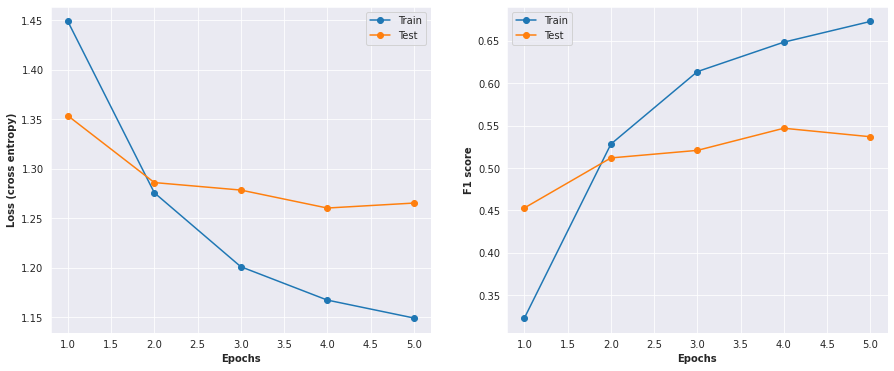

CPU times: user 5min 54s, sys: 14.5 s, total: 6min 9s
Wall time: 6min 10s


In [17]:
%time losses_train, losses_test, f1_scores_train, f1_test_test = train(model, train_dl, test_dl, epochs=5, lr=1e-5)

### Evaluación

In [20]:
%time y_test, y_pred = infer(model, test_dl)

CPU times: user 10.1 s, sys: 201 ms, total: 10.3 s
Wall time: 10.5 s


In [21]:
print(classification_report(y_test, y_pred, target_names=['ideological-inequality', 'misogyny-non-sexual-violence', 
                                                          'objectification', 'sexual-violence', 'stereotyping-dominance']))

                              precision    recall  f1-score   support

      ideological-inequality       0.68      0.80      0.74       621
misogyny-non-sexual-violence       0.61      0.49      0.54       472
             objectification       0.60      0.52      0.56       324
             sexual-violence       0.76      0.61      0.68       400
      stereotyping-dominance       0.54      0.68      0.60       464

                    accuracy                           0.64      2281
                   macro avg       0.64      0.62      0.62      2281
                weighted avg       0.64      0.64      0.63      2281



In [22]:
print(f'Accuracy: {100*round(accuracy_score(y_test, y_pred), 4)}')
print(f'F1 score: {100*round(f1_score(y_test, y_pred, average="macro"), 4)}')

Accuracy: 63.7
F1 score: 62.38


In [23]:
text = 'shut up bitch and suck my dick'

predict_sexism(model, text, label=True)

'sexual-violence'

- De igual manera, parece que hacer el spell-checking no ayuda. 
- Usar  `torch.mean(bert_output, dim=1)` en vez de `bert_output[:,0,:]` como entrada para el clasificador realmente ayuda.

|                **Model**                | **Accuracy** | **F1** |
|:---------------------------------------:|:------------:|:------:|
| BERT-base-multilingual-uncased, lr=1e-5 |     63.70    |  62.38 |
| BERT-base-multilingual-uncased, lr=2e-5 |     53.97    |  48.19 |
| BERT-base-multilingual-uncased, lr=3e-5 |       -      |    -   |



<!-- |                 **Model**                 | **Accuracy** | **F1** |
|:-----------------------------------------:|:------------:|:------:|
|       1-Dropout, bert_output[:,0,:]       |    73.509    | 73.240 |
|       2-Dropout, bert_output[:,0,:]       |     74.18    |  76.22 |
|       3-Dropout, bert_output[:,0,:]       |     74.24    |  74.99 |
| 1-Dropout, torch.mean(bert_output, dim=1) |     75.27    |  76.55 |
| 2-Dropout, torch.mean(bert_output, dim=1) |       -      |    -   |
| 3-Dropout, torch.mean(bert_output, dim=1) |     74.52    |  74.81 | -->

Finalmente, guardamos el modelo.

In [24]:
!mkdir models

In [25]:
torch.save(model.state_dict(), 'models/sexism-classifier-task2.pt')